In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
from sklearn.cross_validation import cross_val_score, train_test_split
#from sklearn.decomposition import KernelPCA
#from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
df = pd.read_csv('dataCleanNoOutlier.csv')
# Drop the Week column, same info is captured in weekno
df = df.drop('Week', 1)
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
0,178480,1,1,0,987718,983958.0000,31589,4715,105901,1519,...,198063.75,574369156,10.084391,3717184,0.000519,23343103440,25,0.822984,2245432996,10.766082
1,185390,2,1,0,660136,907388.9167,30428,4540,108652,1589,...,196355.00,600740100,10.106836,4137156,0.000492,21755266688,36,0.748511,8690900625,11.442771
2,178130,3,1,0,604606,852862.4167,30715,4417,119398,1595,...,194301.80,664144441,10.157005,10569001,0.000308,22414206939,49,0.663123,42966656656,12.241845
3,185020,4,1,0,560656,851885.3333,31632,4372,134819,1606,...,196355.00,679540624,10.168464,37601424,0.000163,21358244109,64,0.568065,4117917241,11.069307
4,170950,5,1,0,326112,827164.4167,NaN,4431,115865,1522,...,216089.00,581533225,10.090589,3069504,0.000571,NaN,81,0.464723,2996248644,10.910313


In [3]:
def rescale(x):
    '''
    Rescale a vector x such that all values lie on the interval [0, 1]
    x: an np.array
    '''
    x = x - np.min(x)
    x = x / np.max(x)
    return x

# Test
x = np.array([4, 3, 9, 1, 7, 11])
rescale(x)

array([ 0.3,  0.2,  0.8,  0. ,  0.6,  1. ])

In [4]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

In [5]:
# Transform each of the following by their optimal exponential transform
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['Fbpostimp'] = df['Fbpostimp'] ** 0.33
df['Fbpostimplag'] = df['Fbpostimplag'] ** 0.29
df['Fblikes'] = df['Fblikes'] ** 0.60
df['Fbengage'] = df['Fbengage'] ** 0.44
df['Twpostimp'] = df['Twpostimp'] ** 0.29

In [6]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

In [7]:
df.fillna(method = 'ffill', axis = 0, inplace = True)
df.fillna(method = 'bfill', axis = 0, inplace = True)

In [8]:
def sse(mod, X, y):
    predictions = mod.predict(X)
    sq_error = [
        (pred - actual) ** 2 for (pred, actual) in zip(predictions, y)]
    RSS = sum(sq_error)
    
    return(RSS)

In [9]:
currentBest = {'model': 'ridge_clf', 'sse': 4972919587.0328007}

# Further Exploration of Interaction Terms
Although there has been some limited exploration of interaction terms, none of the best models have made use of these terms.  Given that a number of the predictors appear to have periodic that coincide, it seems reasonable that there may be important interactions that have been missed.  To explore this in a more systematic way, compare correlations between pairs of predictors and the response. For example:

In [10]:
interactions = []
interaction_corrs = []

for i in range(1, 46):
    for j in range(i + 1, 47):
        interaction = df.ix[:, i] * df.ix[:, j]
        correlation = abs(pearsonr(df.ix[:, 0], interaction)[0])
        interactions.append('{}:{}'.format(df.columns.values[i], df.columns.values[j]))
        interaction_corrs.append(correlation)

In [11]:
cordf = pd.DataFrame(interactions, columns = ['interactions'])
cordf['abs_correlations'] = interaction_corrs
cordf.sort_values(by = 'abs_correlations', ascending = False, inplace = True)
cordf.index = range(cordf.shape[0])
cordf.head(10)

,interactions,abs_correlations
0,organicnew:rev1weekAgo,0.692465
1,organicnew:rev3weekAgo,0.661738
2,brandpaid:organicnew,0.654123
3,organicnew:rev2weekAgo,0.646716
4,organicnew:rev4weekAgo,0.641619
5,organicnew:Fbpostimplag,0.627440
6,brandpaid:rev1weekAgo,0.598747
7,highseason:organicnew,0.595880
8,organicnew:youtube,0.577173
9,organicnew:youtubelag,0.574794


Add interaction columns to df

In [12]:
for i in range(10):
    cols = cordf['interactions'][i]
    orig_cols = cols.split(':')
    df[cols] = df[orig_cols[0]] * df[orig_cols[1]]
    
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,organicnew:rev1weekAgo,organicnew:rev3weekAgo,brandpaid:organicnew,organicnew:rev2weekAgo,organicnew:rev4weekAgo,organicnew:Fbpostimplag,brandpaid:rev1weekAgo,highseason:organicnew,organicnew:youtube,organicnew:youtubelag
0,178480,1,1,0,0.064597,0.073350,0.491038,0.087455,0.134651,0.131320,...,0.639412,0.639412,0.397723,0.639412,0.639412,0.568964,0.387642,0.809963,0.300182,0.294394
1,185390,2,1,0,0.035944,0.062603,0.470952,0.042835,0.146745,0.155073,...,0.678238,0.678238,0.404616,0.678238,0.678238,0.596404,0.371785,0.859145,0.409169,0.354803
2,178130,3,1,0,0.031087,0.054949,0.475917,0.011474,0.193984,0.157109,...,0.818698,0.768237,0.463138,0.768237,0.768237,0.678948,0.400383,0.973149,0.358641,0.446959
3,185020,4,1,0,0.027243,0.054812,0.491782,0.000000,0.261776,0.160842,...,0.786808,0.789434,0.491782,0.841288,0.789434,0.692028,0.386938,1.000000,0.211041,0.427889
4,170950,5,1,0,0.006728,0.051342,0.491782,0.015043,0.178453,0.132338,...,0.690458,0.692745,0.404950,0.647884,0.650047,0.569839,0.412365,0.823434,0.173632,0.299396


In [13]:
# Don't forget to recreate test/train sets!
# Separate df into X (predictors) and y (response)
df.shape

(117, 67)

In [14]:
X = df.ix[:, 1:68]
y = df.ix[:, 0]

# Now split each into testing and training sets
# Ideally, we would stratify the data, but there are too few data in this
# sample 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 11)

In [15]:
X_train.head()

,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,organicnew,...,organicnew:rev1weekAgo,organicnew:rev3weekAgo,brandpaid:organicnew,organicnew:rev2weekAgo,organicnew:rev4weekAgo,organicnew:Fbpostimplag,brandpaid:rev1weekAgo,highseason:organicnew,organicnew:youtube,organicnew:youtubelag
110,111,1,0,0.504781,0.965312,0.442370,0.614227,0.370969,0.487954,0.518850,...,0.282514,0.301164,0.229524,0.331221,0.311793,0.305120,0.240870,0.518850,0.446364,0.472873
28,29,0,0,0.060270,0.060954,0.481003,0.601989,0.171516,0.268069,0.594431,...,0.338878,0.366802,0.285923,0.275001,0.301230,0.361566,0.274215,0.000000,0.103296,0.038972
51,52,1,0,0.402618,0.373283,0.595848,0.993881,0.534335,0.441127,0.834825,...,0.518148,0.580293,0.497429,0.535501,0.096977,0.781028,0.369823,0.834825,0.518300,0.435800
56,57,1,0,0.420757,0.605760,0.645554,0.648649,0.387652,0.377672,0.917639,...,0.707407,0.809252,0.592385,0.788525,0.718906,0.757653,0.497657,0.917639,0.608404,0.693622
39,40,1,0,0.201701,0.142477,0.703339,0.789648,0.341876,0.415677,0.707983,...,0.322859,0.372799,0.497952,0.305114,0.503015,0.632490,0.320741,0.707983,0.323618,0.341021


In [16]:
pipe_lasso = Pipeline([(
            'clf', Lasso(random_state = 11, max_iter = 1000000))])
alpha_range = np.linspace(1, 100, 30)
train_scores, test_scores = validation_curve(estimator = pipe_lasso,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

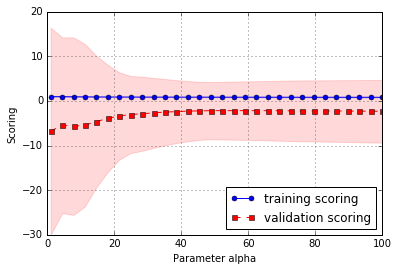

In [20]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training scoring');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation scoring');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
#plt.xscale('log');
plt.legend(loc = 'lower right');
plt.xlabel('Parameter alpha');
plt.ylabel('Scoring');
#plt.ylim([-2.5, -2]); # zoom to see alpha peak at ~ 50
plt.show();

In [21]:
lasso_clf2 = Lasso(alpha = 50, random_state = 11, max_iter = 1000000) 
lasso_clf2.fit(X_train, y_train)
sse(lasso_clf2, X_test, y_test)

6077442898.7714729

In [22]:
currentBest

{'model': 'ridge_clf', 'sse': 4972919587.032801}

In [23]:
#zip(df.columns.values, lasso_clf2.coef_)
# As before: the first predictor is the intercept term, NOT 'revenue'

In [24]:
#X_train.shape
#X_train.ix[1, 0:63]

In [25]:
pipe_ridge = Pipeline([('clf', Ridge(random_state = 11))])

alpha_range = np.linspace(0, 30, num = 30)
# ipython gets hung up if you attempt to use the entire X_train data, so 
# a few cols are omitted here
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train.ix[:, 0:63],
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 30,
                                             n_jobs = -1)

In [26]:
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

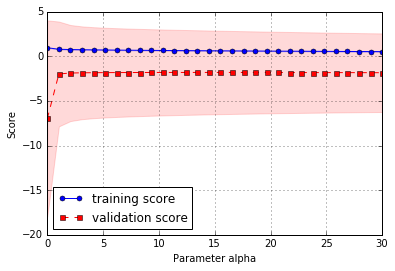

In [29]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training score');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation score');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
plt.legend(loc = 'lower left');
#plt.xscale('log');
plt.xlabel('Parameter alpha');
plt.ylabel('Score');
#plt.ylim([-2, -1.5]); # uncomment to zoom in to see peak alpha ~ 15 better
plt.show();

In [30]:
ridge_clf2 = Ridge(alpha = 15, random_state = 11) # 2.x, 4.5
ridge_clf2.fit(X_train, y_train)
sse(ridge_clf2, X_test, y_test)

4944734510.2145338

In [31]:
currentBest

{'model': 'ridge_clf', 'sse': 4972919587.032801}

In [32]:
# A slight improvement.  Update:
currentBest = { 'model': 'ridge_clf2', 
                'sse': sse(ridge_clf2, X_test, y_test)}

In [33]:
avg_error = np.sqrt(currentBest['sse'] / len(y_test))
print 'Avg. error: $%.2f' % avg_error
print 'Std Dev. of revenue: $%.2f'%np.std(df['revenue'])

Avg. error: $12838.40
Std Dev. of revenue: $23841.97


Just to get a visual sense of how well the current best model is performing, plot the revenue with it's mean and the interval of ± 1sd and ± avg. model error

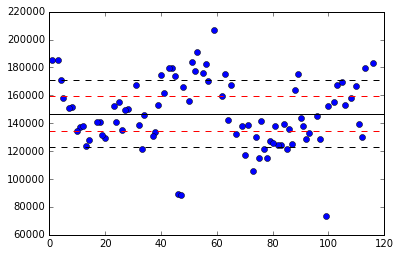

In [34]:
plt.plot(y_train, 'bo');
m = np.mean(y_train)
s = np.std(y_train)
plt.plot((0, 120), (m, m), 'k-');
plt.plot((0, 120), (m + s, m + s), 'k--');
plt.plot((0, 120), (m - s, m - s), 'k--');
plt.plot((0, 120), (m + avg_error, m + avg_error), 'r--');
plt.plot((0, 120), (m - avg_error, m - avg_error), 'r--');